# Fine-tunning for classification 

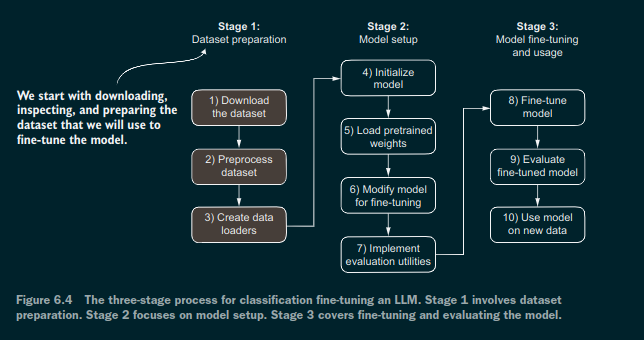

# Preparing the dataset

## Download the data

In [1]:
# Download the data

import urllib.request 
import zipfile 
import os 
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "fine_tunning/sms_spam_collection.zip" 
extracted_path = "fine_tunning/sms_spam_collection" 
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data( url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download ""and extraction.") 
        return

    # download the file 
    with urllib.request.urlopen(url) as response: 
        with open(zip_path, "wb") as out_file: 
            out_file.write(response.read())

    # Unzips the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref: 
        zip_ref.extractall(extracted_path)

    # Adds .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection" 
    os.rename(original_file_path, data_file_path) 
    print(f"File downloaded and saved as {data_file_path}")
    
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

fine_tunning/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [2]:
import pandas as pd 
df = pd.read_csv( data_file_path, sep="\t", header=None, names=["Label", "Text"]) 
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Pre-process the data

In [3]:
from networkx import balanced_tree

print("Summary of orginal data")
print(df["Label"].value_counts())

spam_df = df[df["Label"] == "spam"]
ham_df = df[df["Label"] == "ham"].sample(spam_df.shape[0],random_state=123)

balanced_df = pd.concat([ham_df,spam_df])
print("\nSummary of balanced data")
print(balanced_df["Label"].value_counts())

#convert output string labels into integer
balanced_df["Label"] = balanced_df["Label"].map({ "ham" : 1, "spam" : 1 })
balanced_df

Summary of orginal data
Label
ham     4825
spam     747
Name: count, dtype: int64

Summary of balanced data
Label
ham     747
spam    747
Name: count, dtype: int64


,Label,Text
4307,1,Awww dat is sweet! We can think of something t...
4138,1,Just got to &lt;#&gt;
4831,1,"The word ""Checkmate"" in chess comes from the P..."
4461,1,This is wishing you a great day. Moji told me ...
5440,1,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [4]:
# Splitting the dataset into train , validation and test set
def random_split(df, train_fac, val_fac):

    df = df.sample(frac=1,random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_fac)
    val_end = train_end + int(len(df) * val_fac)

    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]

    return train_df, val_df, test_df

train_df , val_df, test_df = random_split(balanced_df,0.7,0.1)

print(f"Train len {train_df.shape[0]} , Val len {val_df.shape[0]} Test len {test_df.shape[0]}")
train_df.to_csv("fine_tunning/train.csv",index=None)
val_df.to_csv("fine_tunning/validation.csv",index=None)
test_df.to_csv("fine_tunning/test.csv",index=None)

Train len 1045 , Val len 149 Test len 300


In [5]:
import tiktoken 
tokenizer = tiktoken.get_encoding("gpt2") 
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


## Create data loaders

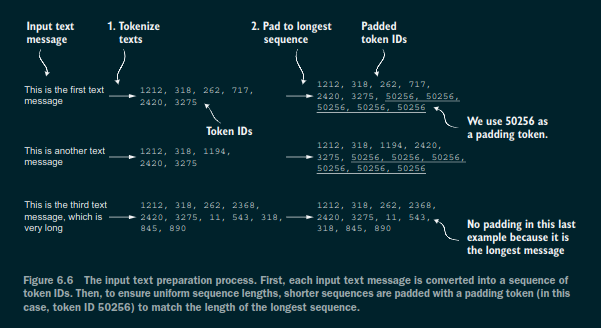

In [6]:
import torch 
from torch.utils.data import Dataset

class SpamDataset(Dataset): 
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256): 
        self.data = pd.read_csv(csv_file) 
        self.encoded_texts = [ tokenizer.encode(text) for text in self.data["Text"]]

        if max_length is None: 
            self.max_length = self._longest_encoded_length() 
        else: 
            self.max_length = max_length 
            
            self.encoded_texts = [ 
                encoded_text[:self.max_length] 
                for encoded_text in self.encoded_texts
            ]
        
        self.encoded_texts = [
             encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) 
             for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index] 
        label = self.data.iloc[index]["Label"] 
        return ( 
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self): 
        return len(self.data)
    
    def _longest_encoded_length(self): 
        max_length = 0 
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text) 
            
            if encoded_length > max_length: 
                max_length = encoded_length 
            
        return max_length

In [7]:
train_dataset = SpamDataset( csv_file="fine_tunning/train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset( csv_file="fine_tunning/validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset( csv_file="fine_tunning/test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

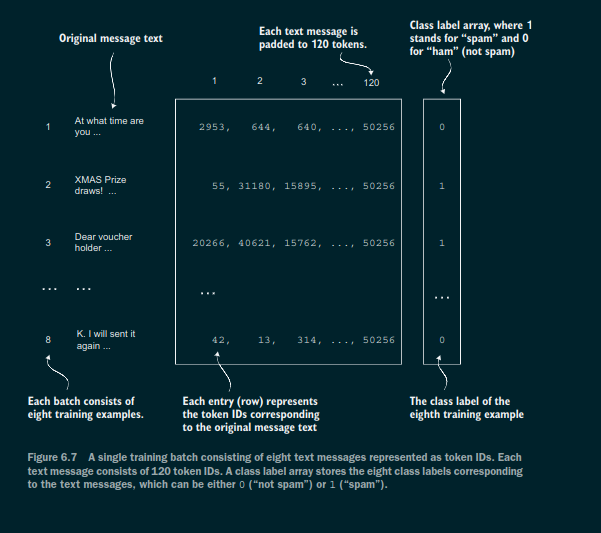

In [8]:
from torch.utils.data import DataLoader

num_workers = 1
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    num_workers=num_workers,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False
)

val_loader = DataLoader(
    dataset=val_dataset,
    num_workers=num_workers,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    num_workers=num_workers,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
)

In [9]:
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimentions ", input_batch.shape)
print("Target batch dimentions ",target_batch.shape)

print(f"{len(train_loader)} training batches") 
print(f"{len(val_loader)} validation batches") 
print(f"{len(test_loader)} test batches")

Input batch dimentions  torch.Size([5, 120])
Target batch dimentions  torch.Size([5])
131 training batches
19 validation batches
38 test batches


# Initializing a model with pretrained weights

In [10]:
CHOOSE_MODEL = "gpt2-small (124M)" 
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
    }

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
} 

BASE_CONFIG.update(model_configs[CHOOSE_MODEL]) 

import nbimporter
from gpt_download import download_and_load_gpt2
from chp05_pretraining import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")") 
settings, params = download_and_load_gpt2( model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG) 
load_weights_into_gpt(model, params) 
model.eval()

2025-06-10 13:41:36.809423: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 13:41:43.687223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 13:41:43.687268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 13:41:43.756478: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-10 13:41:47.361980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2025-06-10 13:43:56.170693: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [11]:
# check model prediction capacity 

from chp04_gpt_model import generate_text_simple 
from chp05_pretraining import text_to_token_ids, token_ids_to_text 

text_1 = "Every effort moves you" 
token_ids = generate_text_simple( 
    model=model, 
    idx=text_to_token_ids(text_1, tokenizer), 
    max_new_tokens=15, 
    context_size=BASE_CONFIG["context_length"]
    ) 
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you eatenitage eaten eaten eaten eaten eaten eaten eaten Aster Done eaten Aster recountsitage


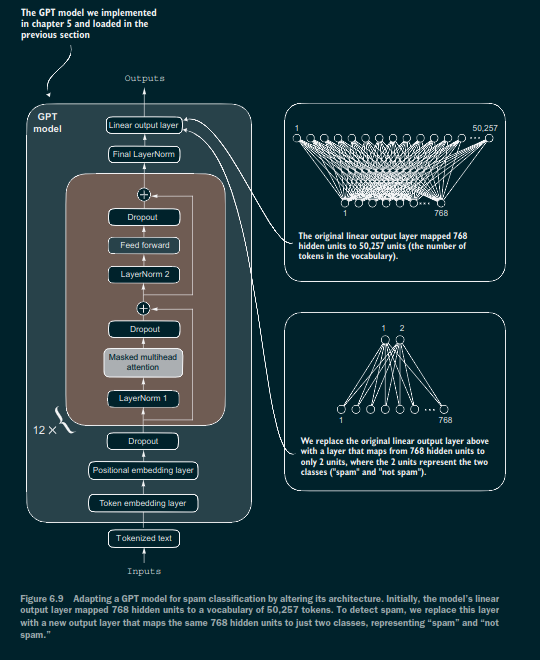

In [12]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

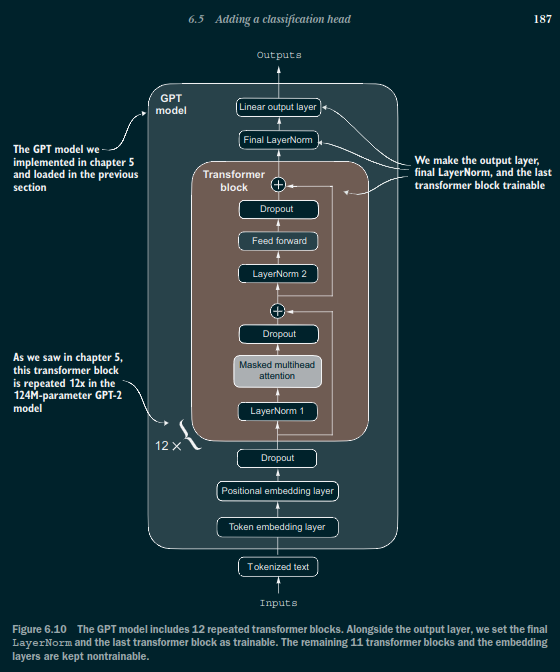

In [13]:
# freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# replacing the output layer with Linear classification layer
torch.manual_seed(123) 
num_classes = 2 
model.out_head = torch.nn.Linear( in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

# To make the final LayerNorm and last transformer block trainable, 
# we set their respective requires_grad to True:

for param in model.trf_blocks[-1].parameters(): 
    param.requires_grad = True 
for param in model.final_norm.parameters(): 
    param.requires_grad = True

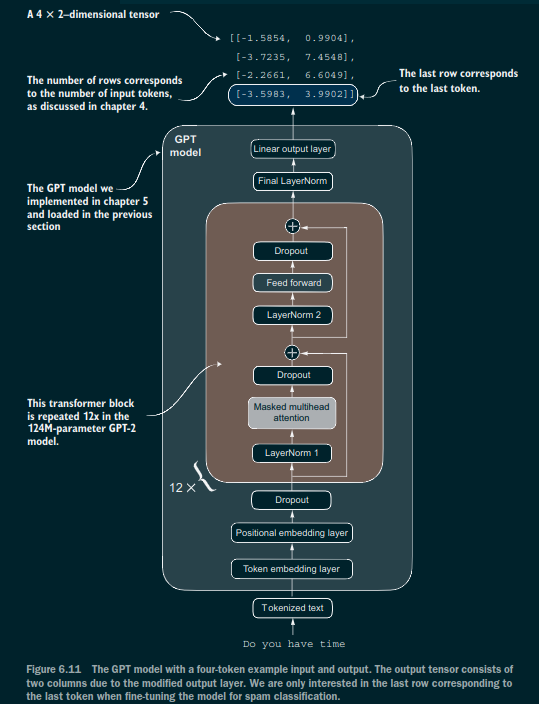

In [14]:
inputs = tokenizer.encode("Do you have time") 
inputs = torch.tensor(inputs).unsqueeze(0) 
print("Inputs:", inputs) 
print("Inputs dimensions:", inputs.shape)

with torch.no_grad(): 
    outputs = model(inputs) 
    print("Outputs:\n", outputs) 
    print("Outputs dimensions:", outputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-0.6458, -0.7218],
         [-0.8805, -0.3163],
         [-1.1334, -0.7274],
         [-1.3001, -0.9750]]])
Outputs dimensions: torch.Size([1, 4, 2])


# Calculating the classification loss and accuracy

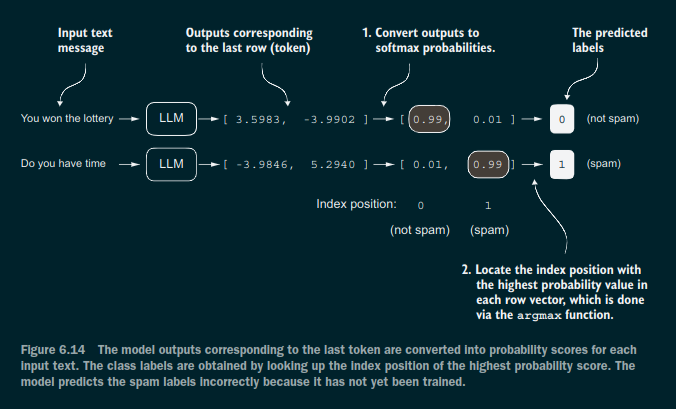

In [15]:
print("Last output token:", outputs[:, -1, :]) 

probas = torch.softmax(outputs[:, -1, :], dim=-1)  
label = torch.argmax(probas) 
print("Class label:", label.item()) 

logits = outputs[:, -1, :] 
label = torch.argmax(logits) 
print("Class label:", label.item()) 

Last output token: tensor([[-1.3001, -0.9750]])
Class label: 1
Class label: 1


In [16]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval() 
    correct_predictions, num_examples = 0, 0
    if num_batches is None: 
        num_batches = len(data_loader) 
    else: 
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches: 
            input_batch = input_batch.to(device) 
            target_batch = target_batch.to(device)       

            with torch.no_grad(): 
                logits = model(input_batch)[:, -1, :] 
            predicted_labels = torch.argmax(logits, dim=-1) 

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else: 
            break 
        return correct_predictions / num_examples
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device) 
torch.manual_seed(123) 
train_accuracy = calc_accuracy_loader( train_loader, model, device, num_batches=10) 
val_accuracy = calc_accuracy_loader( val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader( test_loader, model, device, num_batches=10) 

print(f"Training accuracy: {train_accuracy*100:.2f}%") 
print(f"Validation accuracy: {val_accuracy*100:.2f}%") 
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 0.00%
Validation accuracy: 0.00%
Test accuracy: 0.00%


## Calculating the classification loss

In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device) 
    target_batch = target_batch.to(device) 
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None): 
    total_loss = 0. 
    if len(data_loader) == 0: 
        return float("nan") 
    elif num_batches is None: 
        num_batches = len(data_loader) 
    else: num_batches = min(num_batches, len(data_loader)) 
    
    for i, (input_batch, target_batch) in enumerate(data_loader): 
        if i < num_batches: 
            loss = calc_loss_batch( input_batch, target_batch, model, device) 
            total_loss += loss.item() 
        else: 
            break 
        
    return total_loss / num_batches

with torch.no_grad(): 
    train_loss = calc_loss_loader( train_loader, model, device, num_batches=5) 
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5) 
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}") 
print(f"Validation loss: {val_loss:.3f}") 
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.866
Validation loss: 0.865
Test loss: 0.867


# Fine-tuning the model on supervised data

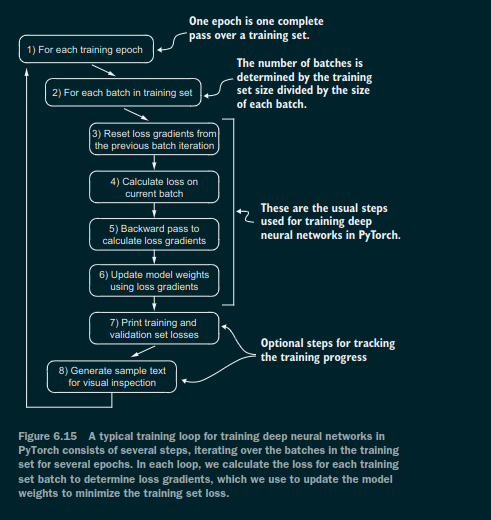

In [18]:
# Fine-tuning the model to classify spam

def evaluate_model(model, train_loader, val_loader, device, eval_iter): 
    model.eval() 
    with torch.no_grad():
        train_loss = calc_loss_loader( train_loader, model, device, num_batches=eval_iter) 
        val_loss = calc_loss_loader( val_loader, model, device, num_batches=eval_iter)

    model.train() 
    return train_loss, val_loss

def train_classifier_simple( model, train_loader, val_loader, optimizer, device,
                             num_epochs, eval_freq, eval_iter):
    
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], [] 
    examples_seen, global_step = 0, -1

    # Main Training loop
    for epoch in range(num_epochs):
        # Sets model in training mode
        model.train()

        for input_batch, target_batch in train_loader:
            # Resets the gradients
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            # calculate loss gradients
            loss.backward()
            # updates the model weights using the loss gradients
            optimizer.step()

            examples_seen += input_batch.shape[0]
            global_step += 1

            # Optional evaluvation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model( 
                        model, train_loader, val_loader, device, eval_iter
                    ) 
                train_losses.append(train_loss) 
                val_losses.append(val_loss) 
                print(f"Ep {epoch+1} (Step {global_step:06d}): " 
                      f"Train loss {train_loss:.3f}", 
                      f"Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader( train_loader, model, device, num_batches=eval_iter) 
        val_accuracy = calc_accuracy_loader( val_loader, model, device, num_batches=eval_iter) 
        
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%") 
        train_accs.append(train_accuracy) 
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

import time 
start_time = time.time() 
torch.manual_seed(123) 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1) 
num_epochs = 5 

train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple( 
        model, train_loader, val_loader, optimizer, device, 
        num_epochs=num_epochs, eval_freq=50, 
        eval_iter=5
        ) 
        
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.808 Val loss 0.808
Ep 1 (Step 000050): Train loss 0.027 Val loss 0.027
Ep 1 (Step 000100): Train loss 0.005 Val loss 0.005
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 2 (Step 000150): Train loss 0.002 Val loss 0.002
Ep 2 (Step 000200): Train loss 0.001 Val loss 0.001
Ep 2 (Step 000250): Train loss 0.001 Val loss 0.001
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 3 (Step 000300): Train loss 0.000 Val loss 0.000
Ep 3 (Step 000350): Train loss 0.000 Val loss 0.000
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.000 Val loss 0.000
Ep 4 (Step 000450): Train loss 0.000 Val loss 0.000
Ep 4 (Step 000500): Train loss 0.000 Val loss 0.000
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 5 (Step 000550): Train loss 0.000 Val loss 0.000
Ep 5 (Step 000600): Train loss 0.000 Val loss 0.000
Ep 5 (Step 000650): Train loss 0.000 Val loss 0.000
Training accuracy: 100.00% | Validation 

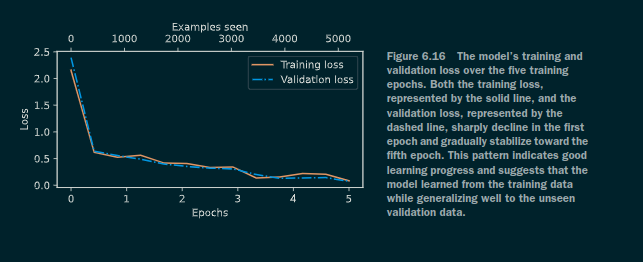

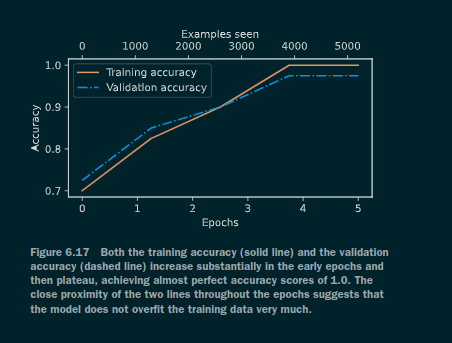

# Using the LLM as a spam classifier

In [19]:
def classify_review( text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # truncate sequences if they are long
    input_ids = input_ids[:min( max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor( input_ids, device=device).unsqueeze(0)

    with torch.no_grad(): 
        logits = model(input_tensor)[:, -1, :] 
    predicted_label = torch.argmax(logits, dim=-1).item() 
    
    return "spam" if predicted_label == 1 else "not spam"


In [20]:
# Example 1
text_1 = ("You are a winner you have been specially"" selected to receive $1000 cash or a $2000 award.")
print(classify_review( text_1, model, tokenizer, device, max_length=train_dataset.max_length))

# Example 2
text_2 = ("Hey, just wanted to check if we're still on"" for dinner tonight? Let me know!") 
print(classify_review( text_2, model, tokenizer, device, max_length=train_dataset.max_length))


spam
spam


In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")
model_state_dict = torch.load("review_classifier.pth, map_location=device") 
model.load_state_dict(model_state_dict)